# Setup

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, ttest_ind

from Bio.SeqUtils import seq1
from Bio.SubsMat.MatrixInfo import blosum62

from IPython.display import display

%matplotlib inline

DIR = r'c://downloads'

pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

# Q1 - Parsing the data

In [2]:
clinvar_variants = pd.read_csv(os.path.join(DIR, 'variant_summary.txt.gz'), delimiter = '\t', na_values = ['-', 'na'], dtype = \
        {'nsv/esv (dbVar)': str, 'Chromosome': str, 'OtherIDs': str})
# Every variant appears twice, one in either of the two reference genome assemblies (GRCh37 and GRCh38). We don't need this
# unnecessary duplication.
clinvar_variants = clinvar_variants[clinvar_variants['Assembly'] == 'GRCh38']
display(clinvar_variants)

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID
0,191195,duplication,NM_006920.6(SCN1A):c.2011-13dup,6323,SCN1A,HGNC:10585,Conflicting interpretations of pathogenicity,0,"Feb 15, 2019",549232924,NaN,RCV000824716;RCV000190444,MedGen:CN517202;MedGen:CN169374,not provided;not specified,germline,germline,GRCh38,NC_000002.12,2,166042429,166042429,T,TA,2q24.3,"criteria provided, conflicting interpretations",3,NaN,N,NaN,2,194032
2,191196,single nucleotide variant,NM_001182.5(ALDH7A1):c.1093+1G>A,501,ALDH7A1,HGNC:877,Pathogenic,1,"Feb 23, 2015",794727058,NaN,RCV000174294,MedGen:CN517202,not provided,germline,germline,GRCh38,NC_000005.10,5,126555930,126555930,C,T,5q23.2,"criteria provided, single submitter",1,NaN,N,NaN,2,194033
4,191197,single nucleotide variant,NM_001195263.2(PDZD7):c.1752T>C (p.Tyr584=),79955,PDZD7,HGNC:26257,Likely benign,0,"Mar 16, 2015",368563439,NaN,RCV000174295,MedGen:CN169374,not specified,germline,germline,GRCh38,NC_000010.11,10,101012256,101012256,A,G,10q24.31,"criteria provided, single submitter",1,NaN,N,NaN,2,194034
6,191198,single nucleotide variant,NM_001369.2(DNAH5):c.1585C>T (p.Arg529Trp),1767,DNAH5,HGNC:2950,Uncertain significance,0,"Oct 25, 2018",200452908,NaN,RCV000463597;RCV000174297,"Human Phenotype Ontology:HP:0012265,MedGen:C00...",Primary ciliary dyskinesia;not provided,germline,germline,GRCh38,NC_000005.10,5,13911445,13911445,G,A,5p15.2,"criteria provided, multiple submitters, no con...",2,NaN,N,NaN,2,194035
8,191199,single nucleotide variant,NM_001429.4(EP300):c.2240C>T (p.Pro747Leu),2033,EP300,HGNC:3373,Benign/Likely benign,0,"Feb 04, 2019",193026103,NaN,RCV000353412;RCV000893330;RCV000174298,"MedGen:C4551859,OMIM:180849,Orphanet:ORPHA3532...",Rubinstein-Taybi syndrome 1;not provided;not s...,germline,germline,GRCh38,NC_000022.11,22,41147945,41147945,C,T,22q13.2,"criteria provided, multiple submitters, no con...",3,NaN,N,NaN,2,194036
10,191200,single nucleotide variant,NM_001110556.2(FLNA):c.1812C>T (p.Asp604=),2316,FLNA,HGNC:3754,Conflicting interpretations of pathogenicity,0,"Jun 14, 2018",370735674,NaN,RCV000253412;RCV000721094;RCV000724189;RCV0002...,MedGen:CN230736;MedGen:C2711754;MedGen:CN51720...,Cardiovascular phenotype;History of neurodevel...,germline,germline,GRCh38,NC_000023.11,X,154364837,154364837,G,A,Xq28,"criteria provided, conflicting interpretations",3,NaN,N,NaN,2,194037
12,191201,single nucleotide variant,NM_001458.4(FLNC):c.1902G>A (p.Glu634=),2318,FLNC,HGNC:3756,Benign,0,"Feb 27, 2019",12536635,NaN,RCV000541893;RCV000174300,MedGen:CN517202;MedGen:CN169374,not provided;not specified,germline,germline,GRCh38,NC_000007.14,7,128841258,128841258,G,A,7q32.1,"criteria provided, multiple submitters, no con...",4,NaN,N,NaN,2,194038
14,191202,single nucleotide variant,NM_001848.2(COL6A1):c.956A>G (p.Lys319Arg),1291,COL6A1,HGNC:2211,Uncertain significance,0,"Sep 24, 2018",794727059,NaN,RCV000821054;RCV000174301,"MedGen:CN029274,OMIM:158810;MedGen:CN517202",Bethlem myopathy 1;not provided,germline,germline,GRCh38,NC_000021.9,21,45990283,45990283,A,G,21q22.3,"criteria provided, multiple submitters, no con...",2,NaN,N,NaN,2,194039
16,191203,single nucleotide variant,NM_001848.2(COL6A1):c.957+2T>C,1291,COL6A1,HGNC:2211,Pathogenic,1,"Aug 06, 2014",794727060,NaN,RCV000174303,MedGen:CN517202,not provided,germline,germline,GRCh38,NC_000021.9,21,45990286,45990286,T,C,21q22.3,"criteria provided, single submitter",1,NaN,N,NaN,2,194040
18,191204,single nucleotide variant,NM_001849.3(COL6A2):c.1070C>G (p.Pro357Arg),1292,COL6A2,HGNC:2212,Conflicting interpretations of pathogenicity,0,"Feb 08, 2019",199929757,NaN,RCV000353406;RCV000300853;RCV000762045;RCV0001...,"MedGen:CN117976

In [3]:
HGVS_PATTERN = re.compile(r'p\.([a-zA-Z]{3})(\d+)([a-zA-Z]{3})')

def parse_protein_hgvs(clinvar_name):
    try:
        (ref_aa, position, alt_aa), = HGVS_PATTERN.findall(clinvar_name)
        return pd.Series({'position': int(position), 'ref_aa': seq1(ref_aa), 'alt_aa': seq1(alt_aa)})
    except:
        return pd.Series({'position': np.nan, 'ref_aa': np.nan, 'alt_aa': np.nan})
        
clinvar_snps = clinvar_variants[clinvar_variants['Type'] == 'single nucleotide variant']
print('%d of the %d variants are single-nucleotide.' % (len(clinvar_snps), len(clinvar_variants)))
clinvar_snps = pd.concat([clinvar_snps, clinvar_snps['Name'].apply(parse_protein_hgvs)], axis = 1)

clinvar_missense_variants = clinvar_snps[pd.notnull(clinvar_snps['alt_aa']) & (clinvar_snps['alt_aa'] != '*') & \
        (clinvar_snps['ref_aa'] != '*') & (clinvar_snps['alt_aa'] != clinvar_snps['ref_aa'])].copy()
print('%d of the %d SNVs are missense variants.' % (len(clinvar_missense_variants), len(clinvar_snps)))

display(clinvar_missense_variants)

547768 of the 630634 variants are single-nucleotide.
240301 of the 547768 SNVs are missense variants.


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,position,ref_aa,alt_aa
6,191198,single nucleotide variant,NM_001369.2(DNAH5):c.1585C>T (p.Arg529Trp),1767,DNAH5,HGNC:2950,Uncertain significance,0,"Oct 25, 2018",200452908,NaN,RCV000463597;RCV000174297,"Human Phenotype Ontology:HP:0012265,MedGen:C00...",Primary ciliary dyskinesia;not provided,germline,germline,GRCh38,NC_000005.10,5,13911445,13911445,G,A,5p15.2,"criteria provided, multiple submitters, no con...",2,NaN,N,NaN,2,194035,529.0,R,W
8,191199,single nucleotide variant,NM_001429.4(EP300):c.2240C>T (p.Pro747Leu),2033,EP300,HGNC:3373,Benign/Likely benign,0,"Feb 04, 2019",193026103,NaN,RCV000353412;RCV000893330;RCV000174298,"MedGen:C4551859,OMIM:180849,Orphanet:ORPHA3532...",Rubinstein-Taybi syndrome 1;not provided;not s...,germline,germline,GRCh38,NC_000022.11,22,41147945,41147945,C,T,22q13.2,"criteria provided, multiple submitters, no con...",3,NaN,N,NaN,2,194036,747.0,P,L
14,191202,single nucleotide variant,NM_001848.2(COL6A1):c.956A>G (p.Lys319Arg),1291,COL6A1,HGNC:2211,Uncertain significance,0,"Sep 24, 2018",794727059,NaN,RCV000821054;RCV000174301,"MedGen:CN029274,OMIM:158810;MedGen:CN517202",Bethlem myopathy 1;not provided,germline,germline,GRCh38,NC_000021.9,21,45990283,45990283,A,G,21q22.3,"criteria provided, multiple submitters, no con...",2,NaN,N,NaN,2,194039,319.0,K,R
18,191204,single nucleotide variant,NM_001849.3(COL6A2):c.1070C>G (p.Pro357Arg),1292,COL6A2,HGNC:2212,Conflicting interpretations of pathogenicity,0,"Feb 08, 2019",199929757,NaN,RCV000353406;RCV000300853;RCV000762045;RCV0001...,"MedGen:CN117976;MedGen:C1611706,Orphanet:ORPHA...",Collagen VI-related myopathy;Myosclerosis;not ...,germline,germline,GRCh38,NC_000021.9,21,46117890,46117890,C,G,21q22.3,"criteria provided, conflicting interpretations",5,NaN,N,NaN,2,194041,357.0,P,R
20,191205,single nucleotide variant,NM_001849.3(COL6A2):c.1063G>T (p.Gly355Cys),1292,COL6A2,HGNC:2212,Likely pathogenic,1,"Sep 02, 2015",794727061,NaN,RCV000392800,MedGen:CN517202,not provided,germline,germline,GRCh38,NC_000021.9,21,46117883,46117883,G,T,21q22.3,"criteria provided, single submitter",1,NaN,N,NaN,2,194042,355.0,G,C
28,191209,single nucleotide variant,NM_002206.3(ITGA7):c.1606C>T (p.Leu536Phe),3679,ITGA7,HGNC:6143,Conflicting interpretations of pathogenicity,0,"Nov 09, 2018",149028067,NaN,RCV000724102;RCV000174309,MedGen:CN517202;MedGen:CN169374,not provided;not specified,germline,germline,GRCh38,NC_000012.12,12,55697030,55697030,G,A,12q13.2,"criteria provided, conflicting interpretations",3,NaN,N,NaN,2,194046,536.0,L,F
40,191216,single nucleotide variant,NM_000109.4(DMD):c.1439G>T (p.Arg480Leu),1756,DMD,HGNC:2928,Uncertain significance,0,"Mar 31, 2015",794727065,NaN,RCV000174328,MedGen:CN517202,not provided,germline,germline,GRCh38,NC_000023.11,X,32614322,32614322,C,A,Xp21.1,"criteria provided, single submitter",1,NaN,N,NaN,2,194053,480.0,R,L
46,191219,single nucleotide variant,NM_004369.3(COL6A3):c.5684C>T (p.Ser1895Leu),1293,COL6A3,HGNC:2213,Uncertain significance,0,"Oct 09, 2014",760532694,NaN,RCV000174331,MedGen:CN517202,not provided,germline,germline,GRCh38,NC_000002.12,2,237365852,237365852,G,A,2q37.3,"criteria provided, single submitter",1,NaN,N,NaN,2,194056,1895.0,S,L
48,191220,single nucleotide variant,NM_004453.4(ETFDH):c.1531G>A (p.Asp511Asn),2110,ETFDH,HGNC:3483,Conflicting interpretations of pathogenicity,1,"Apr 28, 2017",780768015,NaN,RCV000275519;RCV000174333,"MedGen:C0268596,OMIM:231680,SNOMED CT:22886006...","Glutaric aciduria, type 2;not provided",germline,germline,GRCh38,NC_000004.12,4,158706691,158706691,G,A,4q32.1,"criteria provided, conflicting interpretations",2,NaN,N,NaN,2,

# Q1A

t-test p-value = 0


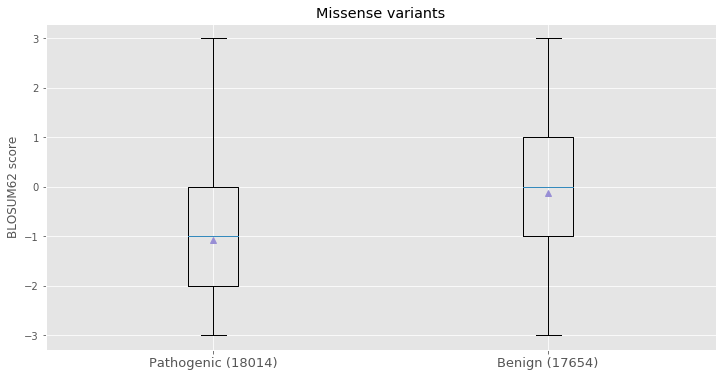

In [4]:
def get_blosum_score(aa1, aa2):
    if (aa1, aa2) in blosum62:
        return blosum62[(aa1, aa2)]
    else:
        return blosum62[(aa2, aa1)]
        
clinvar_missense_variants['blosum_score'] = clinvar_missense_variants.apply(lambda record: get_blosum_score(record['ref_aa'], \
        record['alt_aa']), axis = 1)
pathogenic_blosum_scores = clinvar_missense_variants.loc[clinvar_missense_variants['ClinicalSignificance'] == 'Pathogenic', \
        'blosum_score']
benign_blosum_scores = clinvar_missense_variants.loc[clinvar_missense_variants['ClinicalSignificance'] == 'Benign', \
        'blosum_score']
        
fig, ax = plt.subplots(figsize = (12, 6))
ax.boxplot([pathogenic_blosum_scores, benign_blosum_scores], showmeans = True)
ax.set_xticklabels(['Pathogenic (%d)' % len(pathogenic_blosum_scores), 'Benign (%d)' % len(benign_blosum_scores)], fontsize = 13)
ax.set_ylabel('BLOSUM62 score')
ax.set_title('Missense variants')

_, pval = ttest_ind(pathogenic_blosum_scores, benign_blosum_scores, equal_var = False)
print('t-test p-value = %.1g' % pval)

Pathogenic missense variants clearly take lower BLOSUM62 scores than benign variants. This is expected - lower BLOSUM scores reflect substitutions between amino acids with greater biochemichal functional differences (as reflected by the fact that these substitutions are less favored by natural selection). Greater biochemichal functional differences between the reference to the alternative amino acids mean greater functional damage likely caused by the variant, and, as a result, higher probability of pathogenicity.

# Q1B

In [5]:
GENE_SYMBOL_PATTERN = re.compile('^[A-Z0-9]+$')

determined_clinvar_variants = clinvar_variants[clinvar_variants['ClinicalSignificance'].isin({'Pathogenic', 'Benign'})]
print('%d of the %d variants have a determined clinical significance (either pathogenic or benign).' % \
        (len(determined_clinvar_variants), len(clinvar_variants)))
determined_clinvar_variants = determined_clinvar_variants.dropna(subset = ['GeneSymbol'])
determined_clinvar_variants = determined_clinvar_variants[determined_clinvar_variants['GeneSymbol'].apply(lambda symbol: \
        GENE_SYMBOL_PATTERN.match(symbol) is not None)]
print('%d of these variants affect a single gene.' % len(determined_clinvar_variants))

n_variants_per_gene = determined_clinvar_variants['GeneSymbol'].value_counts()
n_pathogenic_variants_per_gene = determined_clinvar_variants.loc[determined_clinvar_variants['ClinicalSignificance'] == \
        'Pathogenic', 'GeneSymbol'].value_counts().reindex(n_variants_per_gene.index).fillna(0).astype(int)
gene_variant_stats = pd.DataFrame({'n_variants': n_variants_per_gene, 'n_pathogenic_variants': n_pathogenic_variants_per_gene})
gene_variant_stats['freq_of_pathogenic_variants'] = gene_variant_stats['n_pathogenic_variants'] / \
        gene_variant_stats['n_variants']
display(gene_variant_stats)

152956 of the 630634 variants have a determined clinical significance (either pathogenic or benign).
145022 of these variants affect a single gene.


,n_variants,n_pathogenic_variants,freq_of_pathogenic_variants
BRCA2,3882,3219,0.829212
BRCA1,3407,2786,0.817728
DMD,1083,850,0.784857
NF1,1061,991,0.934025
FBN1,909,835,0.918592
MSH2,833,760,0.912365
LDLR,828,777,0.938406
COL4A5,820,756,0.921951
MLH1,782,690,0.882353
APC,719,668,0.929068


Text(0.5,1,'10085 genes')

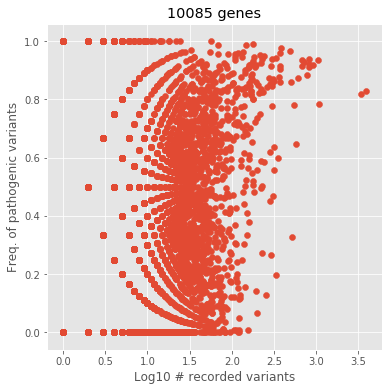

In [6]:
# Plotting the number of recorded variants vs. the frequency of those variants that are pathogenic across all extracted genes.
# Since the number of variants per gene spans several orders of magnitude, it would be better to plot it in log scale.
gene_variant_stats['log10_n_variants'] = np.log10(gene_variant_stats['n_variants'])
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(gene_variant_stats['log10_n_variants'], gene_variant_stats['freq_of_pathogenic_variants'])
ax.set_xlabel('Log10 # recorded variants')
ax.set_ylabel('Freq. of pathogenic variants')
ax.set_title('%d genes' % len(gene_variant_stats))

Although we get a nice-looking graph, it's nearly impossible to understand anything from it. Since both axes are discrete (with the y-axis being mostly discrete for low x values), most gene records simply overlap with one another, and we lose all sense of the true density of the genes. For example, both points (0,0) and (0,1) appear on the graph, and we lose the information that (0,0) is actually far more common (i.e., when we have a gene with a single recorded variants, it far more likely to be benign than pathogenic).

There are several ways to plot the data in a more intelligible way. For example, it might be a good idea to create [2D histograms](https://matplotlib.org/2.0.0/examples/pylab_examples/hist2d_log_demo.html) in such cases, as they preserve the true density of the data. We will take another approach however. We will plot the mean and standard deviation of the frequency of pathogenic variants per number of variants (across all the genes with that number of recorded variants).

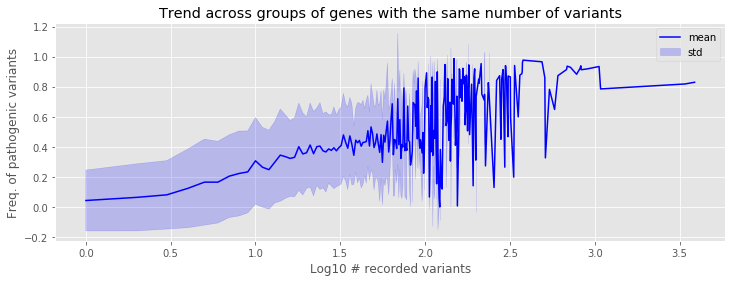

In [7]:
pathogenic_freq_per_log10_n_variants = gene_variant_stats.groupby('log10_n_variants')['freq_of_pathogenic_variants']\
        .agg(['mean', 'std'])
log10_n_variants = pathogenic_freq_per_log10_n_variants.index
mean_pathogenic_freq = pathogenic_freq_per_log10_n_variants['mean']
std_pathogenic_freq = pathogenic_freq_per_log10_n_variants['std']

fig, ax = plt.subplots(figsize = (12, 4))
# Plot the standard dviation as a semi-transparent band around the mean.
std_plot = ax.fill_between(log10_n_variants, mean_pathogenic_freq - std_pathogenic_freq, mean_pathogenic_freq + \
        std_pathogenic_freq, alpha = 0.2, color = 'blue')
mean_plot, = ax.plot(log10_n_variants, mean_pathogenic_freq, color = 'blue')
ax.set_xlabel('Log10 # recorded variants')
ax.set_ylabel('Freq. of pathogenic variants')
ax.set_title('Trend across groups of genes with the same number of variants')
ax.legend([mean_plot, std_plot], ['mean', 'std'])

We begin to see a clear trend: the frequency of pathogenic variants seems to increase with the number of recorded variants. But there is still quite a lot of noise that masks the trend for higher numbers of variants. To smoothen the noise, and hopefully better observe the signal, we can use [exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) with Pandas' `ewm` function.

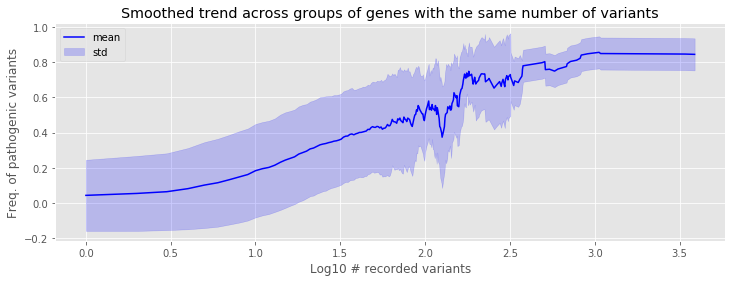

In [8]:
smoothed_pathogenic_freq_per_log10_n_variants = pathogenic_freq_per_log10_n_variants.ewm(span = 20).mean()
log10_n_variants = smoothed_pathogenic_freq_per_log10_n_variants.index
mean_pathogenic_freq = smoothed_pathogenic_freq_per_log10_n_variants['mean']
std_pathogenic_freq = smoothed_pathogenic_freq_per_log10_n_variants['std']

fig, ax = plt.subplots(figsize = (12, 4))
std_plot = ax.fill_between(log10_n_variants, mean_pathogenic_freq - std_pathogenic_freq, mean_pathogenic_freq + \
        std_pathogenic_freq, alpha = 0.2, color = 'blue')
mean_plot, = ax.plot(log10_n_variants, mean_pathogenic_freq, color = 'blue')
ax.set_xlabel('Log10 # recorded variants')
ax.set_ylabel('Freq. of pathogenic variants')
ax.set_title('Smoothed trend across groups of genes with the same number of variants')
ax.legend([mean_plot, std_plot], ['mean', 'std'])

The trend is very clear now.

Let's also test it statistically using Spearman's rank correlation.

In [9]:
print(('Spearman\'s rank correlation between the number of recorded variants per gene to the frequency of the variants ' + \
        'that are pathogenic: ρ = %.2f, p-value = %.1g') % spearmanr(gene_variant_stats['n_variants'], \
        gene_variant_stats['freq_of_pathogenic_variants']))

Spearman's rank correlation between the number of recorded variants per gene to the frequency of the variants that are pathogenic: ρ = 0.63, p-value = 0


We also get a very strong, and undoubtedly significant, correlation.

To summarize, we observe a clear, strong association in ClinVar between the number of recorded variants to the percentage of those variants that are pathogenic across genes. There are many possible explanations for this association, for example:
1. The most likely explanation is that genes with many recorded variants are genes of interest to the community of clinical geneticists. These are, most likely, genes with clinical significance, meaning that variants in those genes are more likely to be pathogenic. This theory is supported by the identiy of many of the top genes on our list - e.g. BRCA2 (3,882 recorded variants), BRCA1 (3,407 variants), NF1 (1,061 variants) - all of which are well-known tumor suppressor genes.
2. Another possible explanation is that the probability of a gene to be pathogenic and the number of overall variants in the gene are confounded by some variables such as the length of the gene. For example, genes at clinically sensitive tissues such as the brain might be longer on average, therefore having more variants.

An interesting followup analysis would be to compare the frequncy of ClinVar pathogenic varaints with the actual number of variants and their allele frequencies in the human population (e.g. using [gnomAD](https://gnomad.broadinstitute.org/)). This would disentangle the number recorded in ClinVar from the actual number of variants in the gene, as captured by unbiased sequencing techniques, thereby allowing us to dicern, at least partially, between explanations rooted in biases of the scientific community to actual biological reasons.